In [2]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib


  Using cached tensorflow-2.18.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata (20 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached wrapt-1.17.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached grpcio-1.70.0-cp312-cp312-macosx_10_14_universal2.whl.metadata (3.9 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.8.0-py3-none-any.whl.metadata (5.8 kB)
  Using cache

In [368]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [7]:
!python --version

Python 3.12.4


In [2]:
import sys
!{sys.executable} -m pip install opencv-python mediapipe scikit-learn matplotlib tensorflow

  Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata (20 kB)
  Using cached mediapipe-0.10.21-cp310-cp310-macosx_11_0_universal2.whl.metadata (9.9 kB)
  Using cached scikit_learn-1.6.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached tensorflow-2.18.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached jax-0.5.0-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.5.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (978 bytes)
  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata (20 kB)
  Using cached sounddevice-0.5.1-py3-none-macosx_10_6_x86_64.macosx_10_6_universal2.whl.metadata (1.4 kB)
  Using cached sentencepiece-0.2.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (7.7 kB)
  Using cached scipy-1.15.2-cp310-cp310-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using c

# 2. Keypoints using MP Holistic

In [3]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     # Read feed
#     ret, frame = cap.read()
#     # Show to screen
#     cv2.imshow('OpenCV Feed', frame)

#     # Break gracefully
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

In [369]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [370]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [371]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [372]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.4

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret:  # Add check for frame capture success
            print("Failed to capture frame from camera")
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # Remove debug print that clutters output
        # print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]  # Keep only last 30 frames
        
        if len(sequence) == 30:
            try:
                # Use a try block to handle any prediction errors
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))
                
                # Only print occasionally to reduce output clutter
                if len(predictions) % 10 == 0:
                    print(f"Predicted: {actions[np.argmax(res)]} with confidence {res[np.argmax(res)]:.2f}")
                
                # 3. Viz logic
                # Check if we have at least 10 predictions and all match
                if len(predictions) >= 10 and np.unique(predictions[-10:])[0] == np.argmax(res): 
                    if res[np.argmax(res)] > threshold: 
                        
                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5: 
                    sentence = sentence[-5:]

                # Viz probabilities - make sure res length matches the expected format
                try:
                    image = prob_viz(res, actions, image, colors)
                except Exception as e:
                    print(f"Error in visualization: {e}")
            except Exception as e:
                print(f"Error in prediction: {e}")
        
        # Draw the sentence box
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Add a small delay to prevent CPU overload
        key = cv2.waitKey(10) & 0xFF
        
        # Break gracefully
        if key == ord('q'):
            break
            
    # Release resources properly
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1742149660.559913 102273912 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1742149660.688544 102274374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742149660.720716 102274378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742149660.726722 102274374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742149660.726877 102274378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742149660.727058 102274372 inference_feedback_manager.cc:114] Feedback manager re

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>


2025-03-16 23:57:41.868 Python[28959:102273912] +[IMKClient subclass]: chose IMKClient_Legacy
2025-03-16 23:57:41.868 Python[28959:102273912] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

# 3. Extract Keypoint Values

In [11]:
len(results.right_hand_landmarks.landmark)

21

In [13]:
len(results.pose_landmarks.landmark)

33

In [14]:
len(results.face_landmarks.landmark)

468

In [373]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [374]:
## multiplying the frames of each array by 3-> number of coordinates
## pose has 3 coordintates plus visibility parameter associated with with np.array so we multiply by 4

In [375]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [376]:
extract_keypoints(results)

array([ 0.4620901 ,  0.57137579, -0.93700039, ...,  0.11434507,
        0.50945479, -0.033866  ])

In [20]:
33*4+468*3+21*3+21*3

1662

# 4. Setup Folders for Collection

In [377]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['cold', 'fever', 'cough', 'medication', 'injection', 'operation', 'pain'])


# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [77]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [78]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.4

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret:  # Add check for frame capture success
            print("Failed to capture frame from camera")
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # Remove debug print that clutters output
        # print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]  # Keep only last 30 frames
        
        if len(sequence) == 30:
            try:
                # Use a try block to handle any prediction errors
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))
                
                # Only print occasionally to reduce output clutter
                if len(predictions) % 10 == 0:
                    print(f"Predicted: {actions[np.argmax(res)]} with confidence {res[np.argmax(res)]:.2f}")
                
                # 3. Viz logic
                # Check if we have at least 10 predictions and all match
                if len(predictions) >= 10 and np.unique(predictions[-10:])[0] == np.argmax(res): 
                    if res[np.argmax(res)] > threshold: 
                        
                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5: 
                    sentence = sentence[-5:]

                # Viz probabilities - make sure res length matches the expected format
                try:
                    image = prob_viz(res, actions, image, colors)
                except Exception as e:
                    print(f"Error in visualization: {e}")
            except Exception as e:
                print(f"Error in prediction: {e}")
        
        # Draw the sentence box
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Add a small delay to prevent CPU overload
        key = cv2.waitKey(10) & 0xFF
        
        # Break gracefully
        if key == ord('q'):
            break
            
    # Release resources properly
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1742389882.465260 102273912 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1742389882.724843 103801645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742389882.856700 103801645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742389882.959994 103801645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742389882.967747 103801648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742389883.002151 103801643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabl

In [366]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [378]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

In [379]:
label_map = {label:num for num, label in enumerate(actions)}

In [380]:
label_map

{'cold': 0,
 'fever': 1,
 'cough': 2,
 'medication': 3,
 'injection': 4,
 'operation': 5,
 'pain': 6}

In [381]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [382]:
np.array(sequences).shape

(210, 30, 1662)

In [383]:
np.array(labels).shape


(210,)

In [384]:
X = np.array(sequences)

In [385]:
X.shape

(210, 30, 1662)

In [386]:
y = to_categorical(labels).astype(int)

In [387]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [388]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [389]:
y_test.shape


(42, 7)

# 7. Build and Train LSTM Neural Network

In [390]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import os

In [350]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [102]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/opt/miniconda3/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
             ^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/tensorboard/main.py", line 38, in run_main
    main_lib.global_init()
  File "/opt/miniconda3/lib/python3.12/site-packages/tensorboard/main_lib.py", line 50, in global_init
    if getattr(tf, "__version__", "stub") == "stub":
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/tensorboard/lazy.py", line 65, in __getattr__
    return getattr(load_once(self), attr_name)
                   ^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/tensorboard/lazy.py", line 97, in wrapper
    cache[arg] = f(arg)
                 ^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/tensorboard/lazy.py", line 50, in load_once
    module = load_fn()
             ^^^

Python(26336) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [103]:
%tensorboard --logdir Logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/opt/miniconda3/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
             ^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/tensorboard/main.py", line 38, in run_main
    main_lib.global_init()
  File "/opt/miniconda3/lib/python3.12/site-packages/tensorboard/main_lib.py", line 50, in global_init
    if getattr(tf, "__version__", "stub") == "stub":
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/tensorboard/lazy.py", line 65, in __getattr__
    return getattr(load_once(self), attr_name)
                   ^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/tensorboard/lazy.py", line 97, in wrapper
    cache[arg] = f(arg)
                 ^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/tensorboard/lazy.py", line 50, in load_once
    module = load_fn()
             ^^^

Python(26344) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [391]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Build an improved model with regularization
model = Sequential()

# Input layer - using tanh activation and L2 regularization
model.add(LSTM(64, 
               activation='tanh',
               return_sequences=True,
               kernel_regularizer=l2(0.001),
               recurrent_regularizer=l2(0.001),
               input_shape=(30, 1662)))
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Lower dropout rate

# Second LSTM layer with bidirectional wrapper
model.add(Bidirectional(LSTM(64, 
                            activation='tanh',
                            return_sequences=False,
                            kernel_regularizer=l2(0.001),
                            recurrent_regularizer=l2(0.001))))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Dense layers - gradually reduce size
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer
model.add(Dense(actions.shape[0], activation='softmax'))

# Use a moderate learning rate
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [296]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# # Build a more robust model
# model = Sequential()
# # Input layer with batch normalization
# model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), 
#                       input_shape=(30, 1662)))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

# # Hidden layers
# model.add(Bidirectional(LSTM(256, return_sequences=True, activation='relu')))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

# model.add(Bidirectional(LSTM(128, return_sequences=False, activation='relu')))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

# # Dense layers
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(actions.shape[0], activation='softmax'))

# # Compile with a lower learning rate
# optimizer = Adam(learning_rate=0.0005)
# model.compile(optimizer=optimizer, 
#               loss='categorical_crossentropy', 
#               metrics=['categorical_accuracy'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [352]:
# Define early stopping and learning rate reduction callbacks
es_callback = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='min', min_lr=0.00001)
mc_callback = ModelCheckpoint('action_best.h5', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

# Train with validation and improved callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,  # Reduce epochs but use early stopping
    batch_size=16,
    callbacks=[tb_callback, es_callback, lr_callback, mc_callback],
    shuffle=True  # Shuffle training data for better generalization
)


Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.1908 - loss: 3.1144
Epoch 1: val_categorical_accuracy improved from -inf to 0.26190, saving model to action_best.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - categorical_accuracy: 0.1948 - loss: 3.0928 - val_categorical_accuracy: 0.2619 - val_loss: 2.8293 - learning_rate: 3.0000e-04
Epoch 2/200
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_accuracy: 0.5643 - loss: 2.1536
Epoch 2: val_categorical_accuracy did not improve from 0.26190
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.5663 - loss: 2.1390 - val_categorical_accuracy: 0.1429 - val_loss: 2.8253 - learning_rate: 3.0000e-04
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.5832 - loss: 1.9965
Epoch 3: val_categorical_accuracy did not improve from 0.26190
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.5852 - loss: 1.9910 - val_categorical_accuracy: 0.1429 - val_loss: 2.8154 - learning_rate: 3.0000e-04
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_accuracy: 0.7172 - loss: 1.7898
Epoch 4: val_categorical_accuracy did not improve from 0.26190
11/11 ━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - categorical_accuracy: 0.9110 - loss: 1.1787 - val_categorical_accuracy: 0.6190 - val_loss: 2.5353 - learning_rate: 3.0000e-04
Epoch 17/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.9393 - loss: 1.1081
Epoch 17: val_categorical_accuracy did not improve from 0.61905
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - categorical_accuracy: 0.9399 - loss: 1.1084 - val_categorical_accuracy: 0.1429 - val_loss: 2.5559 - learning_rate: 3.0000e-04
Epoch 18/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.9260 - loss: 1.1297
Epoch 18: val_categorical_accuracy did not improve from 0.61905
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9247 - loss: 1.1317 - val_categorical_accuracy: 0.2619 - val_loss: 2.5041 - learning_rate: 3.0000e-04
Epoch 19/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.9398 - loss: 1.0822
Epoch 19: val_categorical_accuracy did not improve from 0.61905
11/11 ━

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - categorical_accuracy: 0.9783 - loss: 0.8622 - val_categorical_accuracy: 0.7619 - val_loss: 1.4196 - learning_rate: 1.5000e-04
Epoch 46/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.9904 - loss: 0.8502
Epoch 46: val_categorical_accuracy did not improve from 0.76190
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.9902 - loss: 0.8502 - val_categorical_accuracy: 0.6429 - val_loss: 1.5980 - learning_rate: 1.5000e-04
Epoch 47/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 1.0000 - loss: 0.8663
Epoch 47: val_categorical_accuracy improved from 0.76190 to 0.83333, saving model to action_best.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - categorical_accuracy: 1.0000 - loss: 0.8637 - val_categorical_accuracy: 0.8333 - val_loss: 1.2946 - learning_rate: 1.5000e-04
Epoch 48/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.9906 - loss: 0.8204
Epoch 48: val_categorical_accuracy did not improve from 0.83333
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.9894 - loss: 0.8246 - val_categorical_accuracy: 0.7857 - val_loss: 1.2748 - learning_rate: 1.5000e-04
Epoch 49/200
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.9958 - loss: 0.8282
Epoch 49: val_categorical_accuracy did not improve from 0.83333
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - categorical_accuracy: 0.9945 - loss: 0.8286 - val_categorical_accuracy: 0.6905 - val_loss: 1.5559 - learning_rate: 1.5000e-04
Epoch 50/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.9933 - loss: 0.8411
Epoch 50: val_categorical_accuracy did not improve from 0.83333
11/11 ━

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - categorical_accuracy: 0.9990 - loss: 0.8522 - val_categorical_accuracy: 0.9524 - val_loss: 1.1552 - learning_rate: 1.5000e-04
Epoch 55/200
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9947 - loss: 0.8430
Epoch 55: val_categorical_accuracy did not improve from 0.95238
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - categorical_accuracy: 0.9946 - loss: 0.8412 - val_categorical_accuracy: 0.5000 - val_loss: 3.0426 - learning_rate: 1.5000e-04
Epoch 56/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.9691 - loss: 0.8733
Epoch 56: val_categorical_accuracy did not improve from 0.95238
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.9692 - loss: 0.8736 - val_categorical_accuracy: 0.7381 - val_loss: 1.9486 - learning_rate: 1.5000e-04
Epoch 57/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 1.0000 - loss: 0.7953
Epoch 57: val_categorical_accuracy did not improve from 0.95238
11/11 ━

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - categorical_accuracy: 1.0000 - loss: 0.7532 - val_categorical_accuracy: 0.9762 - val_loss: 0.8912 - learning_rate: 7.5000e-05
Epoch 81/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.9958 - loss: 0.7420
Epoch 81: val_categorical_accuracy did not improve from 0.97619
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.9956 - loss: 0.7427 - val_categorical_accuracy: 0.8810 - val_loss: 1.0040 - learning_rate: 7.5000e-05
Epoch 82/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.9811 - loss: 0.7708
Epoch 82: val_categorical_accuracy did not improve from 0.97619
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.9817 - loss: 0.7707 - val_categorical_accuracy: 0.9762 - val_loss: 0.9019 - learning_rate: 7.5000e-05
Epoch 83/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.9995 - loss: 0.7513
Epoch 83: val_categorical_accuracy did not improve from 0.97619
11/11 ━

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - categorical_accuracy: 0.9945 - loss: 0.7454 - val_categorical_accuracy: 1.0000 - val_loss: 0.7565 - learning_rate: 7.5000e-05
Epoch 91/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.9908 - loss: 0.7596
Epoch 91: val_categorical_accuracy did not improve from 1.00000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.9906 - loss: 0.7596 - val_categorical_accuracy: 0.9762 - val_loss: 0.7903 - learning_rate: 7.5000e-05
Epoch 92/200
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.9970 - loss: 0.7269
Epoch 92: val_categorical_accuracy did not improve from 1.00000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - categorical_accuracy: 0.9965 - loss: 0.7310 - val_categorical_accuracy: 0.8571 - val_loss: 1.0370 - learning_rate: 7.5000e-05
Epoch 93/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 1.0000 - loss: 0.7449
Epoch 93: val_categorical_accuracy did not improve from 1.00000
11/11 ━

In [394]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_61 (LSTM)                  │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 128)            │        66,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513,415 (1.96 MB)

 Trainable params: 512,967 (1.96 MB)

 Non-trainable params: 448 (1.75 KB)

# 8. Make Predictions

In [392]:
res = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


## Model Evaluation and Visualization

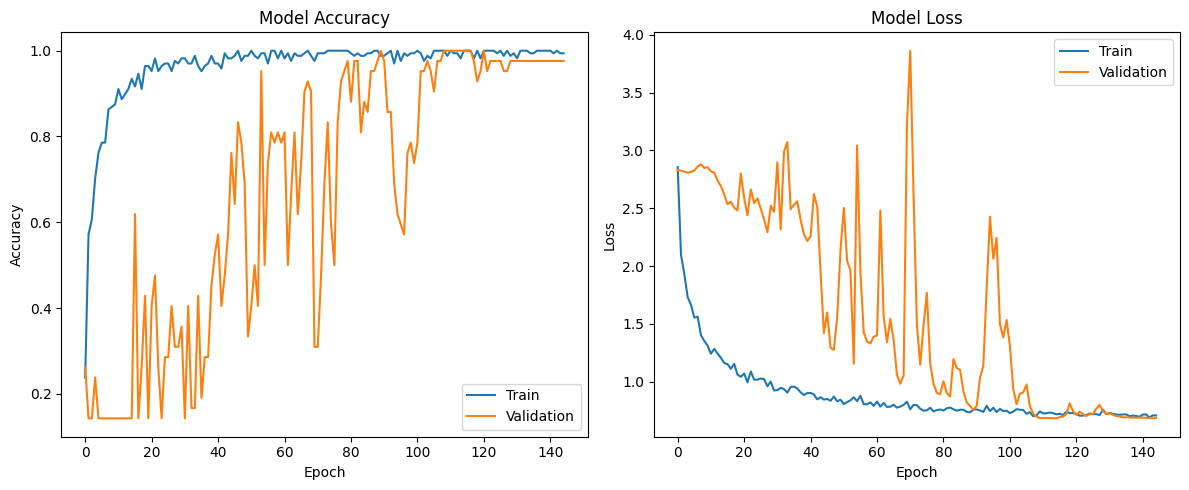

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - categorical_accuracy: 0.1791 - loss: 2.8514 
Test Loss: 2.8514
Test Accuracy: 0.1905
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Confusion Matrix:
[[0 0 0 0 6 0 0]
 [0 0 0 0 6 0 0]
 [0 0 0 0 4 0 2]
 [0 0 0 0 4 0 2]
 [0 0 0 0 6 0 0]
 [0 0 0 0 6 0 0]
 [0 0 0 0 4 0 2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         6
           4       0.17      1.00      0.29         6
           5       0.00      0.00      0.00         6
           6       0.33      0.33      0.33         6

    accuracy                           0.19        42
   macro avg       0.07      0.19      0.09        42
weighted avg       0.07      0.19      0.09        42



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [393]:
# Plot training & validation accuracy/loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Evaluate model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Calculate confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))


In [356]:
actions[np.argmax(res[0])]

'pain'

In [357]:
actions[np.argmax(y_test[0])]

'pain'

# 9. Save Weights

In [233]:
model.save('action.h5')

In [223]:
# del model

In [396]:
model.load_weights('action_best.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [397]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [398]:
yhat = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [399]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(model.predict(X_test), axis=1).tolist()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [400]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[36,  0],
        [ 0,  6]],

       [[36,  0],
        [ 0,  6]],

       [[36,  0],
        [ 0,  6]],

       [[36,  0],
        [ 0,  6]],

       [[36,  0],
        [ 0,  6]],

       [[36,  0],
        [ 0,  6]],

       [[36,  0],
        [ 0,  6]]])

In [401]:
accuracy_score(ytrue, yhat)

1.0

# 11. Test in Real Time

In [402]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        # Make sure we don't exceed the colors list length
        color_idx = num % len(colors)  # Use modulo to cycle through colors if needed
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[color_idx], -1)
        # Same for actions - make sure we don't exceed the actions list length
        if num < len(actions):
            cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [403]:
from scipy import stats

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.4

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret:  # Add check for frame capture success
            print("Failed to capture frame from camera")
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # Remove debug print that clutters output
        # print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]  # Keep only last 30 frames
        
        if len(sequence) == 30:
            try:
                # Use a try block to handle any prediction errors
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))
                
                # Only print occasionally to reduce output clutter
                if len(predictions) % 10 == 0:
                    print(f"Predicted: {actions[np.argmax(res)]} with confidence {res[np.argmax(res)]:.2f}")
                
                # 3. Viz logic
                # Check if we have at least 10 predictions and all match
                if len(predictions) >= 10 and np.unique(predictions[-10:])[0] == np.argmax(res): 
                    if res[np.argmax(res)] > threshold: 
                        
                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5: 
                    sentence = sentence[-5:]

                # Viz probabilities - make sure res length matches the expected format
                try:
                    image = prob_viz(res, actions, image, colors)
                except Exception as e:
                    print(f"Error in visualization: {e}")
            except Exception as e:
                print(f"Error in prediction: {e}")
        
        # Draw the sentence box
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Add a small delay to prevent CPU overload
        key = cv2.waitKey(10) & 0xFF
        
        # Break gracefully
        if key == ord('q'):
            break
            
    # Release resources properly
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1742473650.263963 102273912 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1742473650.550743 104333292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742473650.597779 104333292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742473650.608093 104333298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742473650.609546 104333292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742473650.609612 104333297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabl

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted: cough with confidence 0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted: cough with confidence 0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━